# ДПФ для изображений

Обсудим особенности применения ДПФ к многомерным сигнала, в частности, к изображениям.

Для использования различных методов обработки изображений удобно использовать библиотеку Scikit-image, её можно импортировать командой `import skimage`.

Для загрузки изображения из файла и показа изображений можно воспользоваться методами библиотеки `matplotlib`

Размер: (950, 2400)
Тип im:  <class 'numpy.ndarray'>


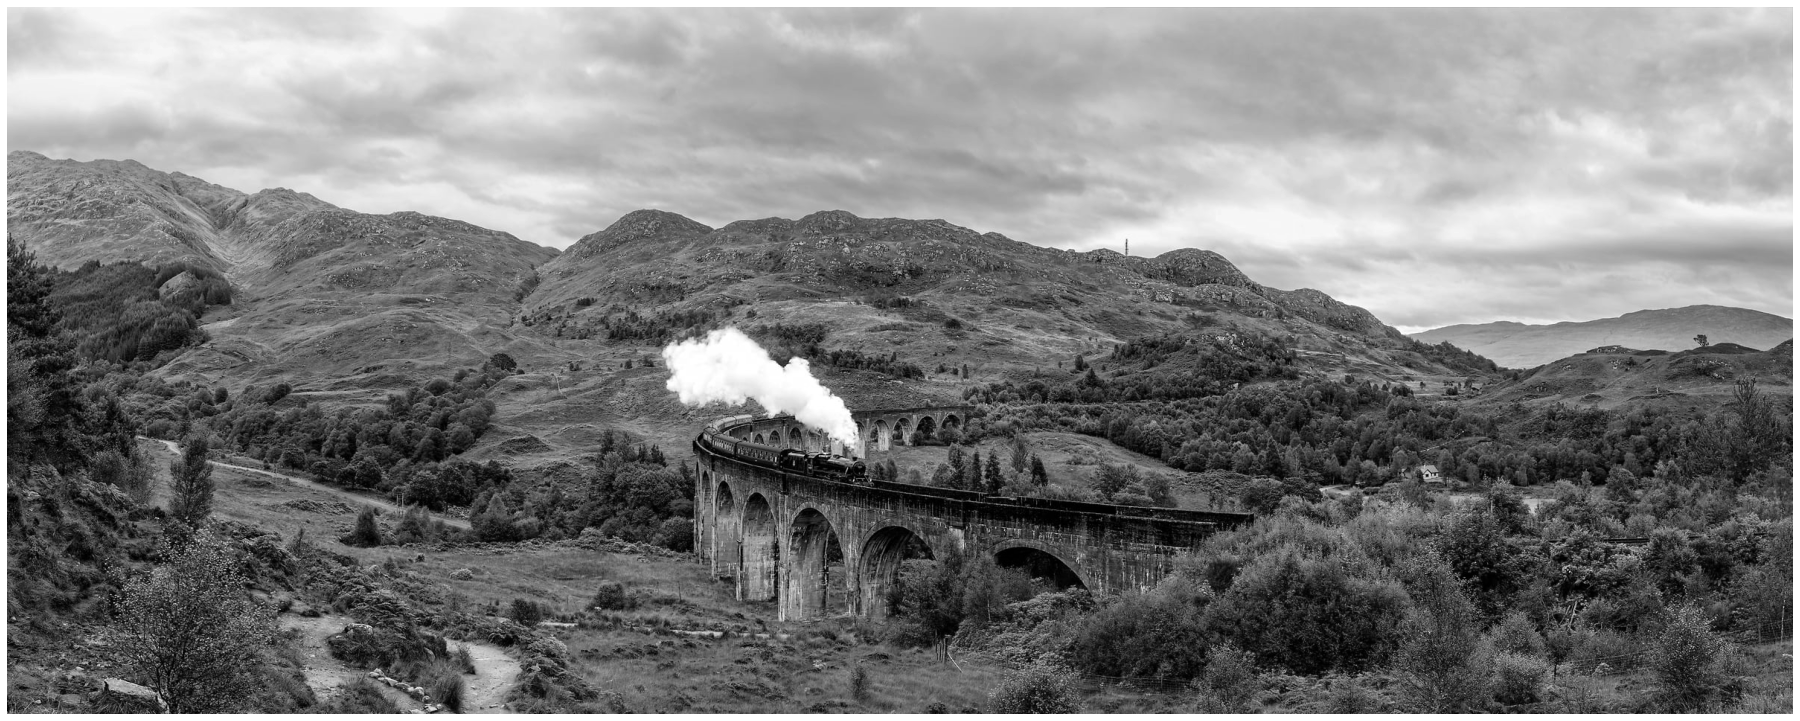

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from scipy.fftpack import fft2, fftshift, ifft2

im = plt.imread('source/test_im2.jpg')
im = color.rgb2gray(im) # RGB к изображению в серых тонах

print('Размер:', im.shape)
print('Тип im: ', type(im))

plt.figure(figsize=(32, 64))
plt.imshow(im, cmap='gray')
plt.axis('off');

Проделаем ДПФ для изображения и изобразим амплитуду полученного спектра также в виде изображения.

(-0.5, 2399.5, 949.5, -0.5)

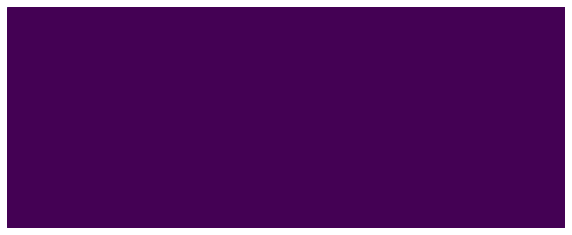

In [2]:
im_fft = fft2(im)
im_fft_A = np.abs(im_fft)

plt.figure(figsize=(10, 5))
plt.imshow(im_fft_A)
plt.axis('off')

На получившемся изображении как будто ничего не видно. Однако, проблема в слишком широком динамическом диапазоне.  Для исправления динамического диапазона можно применить логарифмирование.
Кроме того, низкие частоты располагаются по углам изображения. Это можно исправить командой fftshift, которая сдвинет изображение на половину периода.

(-0.5, 2399.5, 949.5, -0.5)

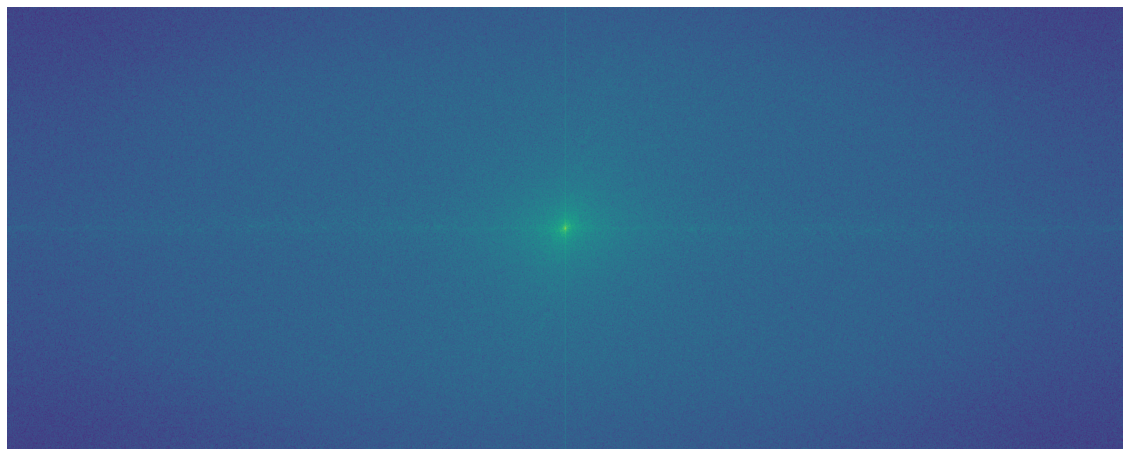

In [4]:
im_fft = fftshift(fft2(im))
im_fft_A = np.abs(im_fft)
plt.figure(figsize=(20, 10))
plt.imshow(np.log(1+im_fft_A))
plt.axis('off')

В итоге мы получили типичный вид ДПФ для изображения: в центре светлое пятно, отвечающие за большие по модулю низкие частоты, которое снижается по интенсивности  к краям.

В этом смысле ДПФ изображений менее информативно, чем ДПФ аудио сигналов. Аудио-сигналы мы слышим частотами и описание звука в терминах частот вполне естественно. В изображениях наоборот мы воспринимаем переходы между яркостью - то есть границы. Воспринимать изображения через частотное содержание для нас не естественно.

Тем не менее, частотная область для изображений также важна для ряда приложений.

### ДПФ для сжатия изображений

Например, в частотной области можно эффективно сжимать изображения.
Идея в том, чтобы применить ДПФ к изображению, среди полученных коэффициентов спектра обнулить те, которые по модулю меньше некоторого порога. А затем провести обратное преобразование Фурье. При удачном подборе порога можно добиться того, что итоговое изображение визуально мало отличается от исходного. При этом вместо хранения всех пикселей можно хранить лишь набор ненулевых коэффициентов спектра.

Приведём код, демонстрирующий этот подход.

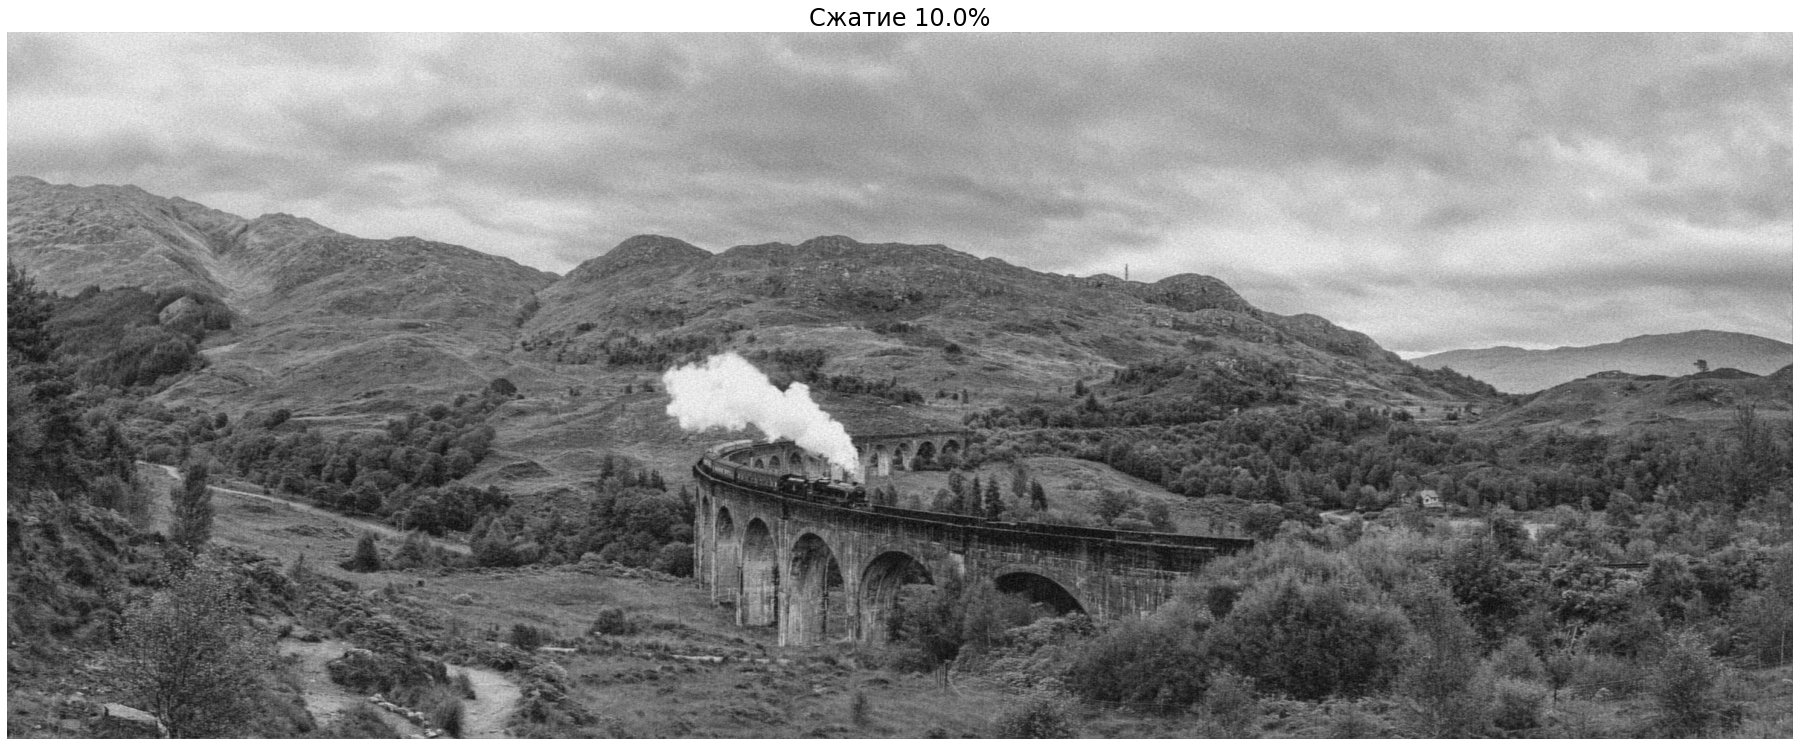

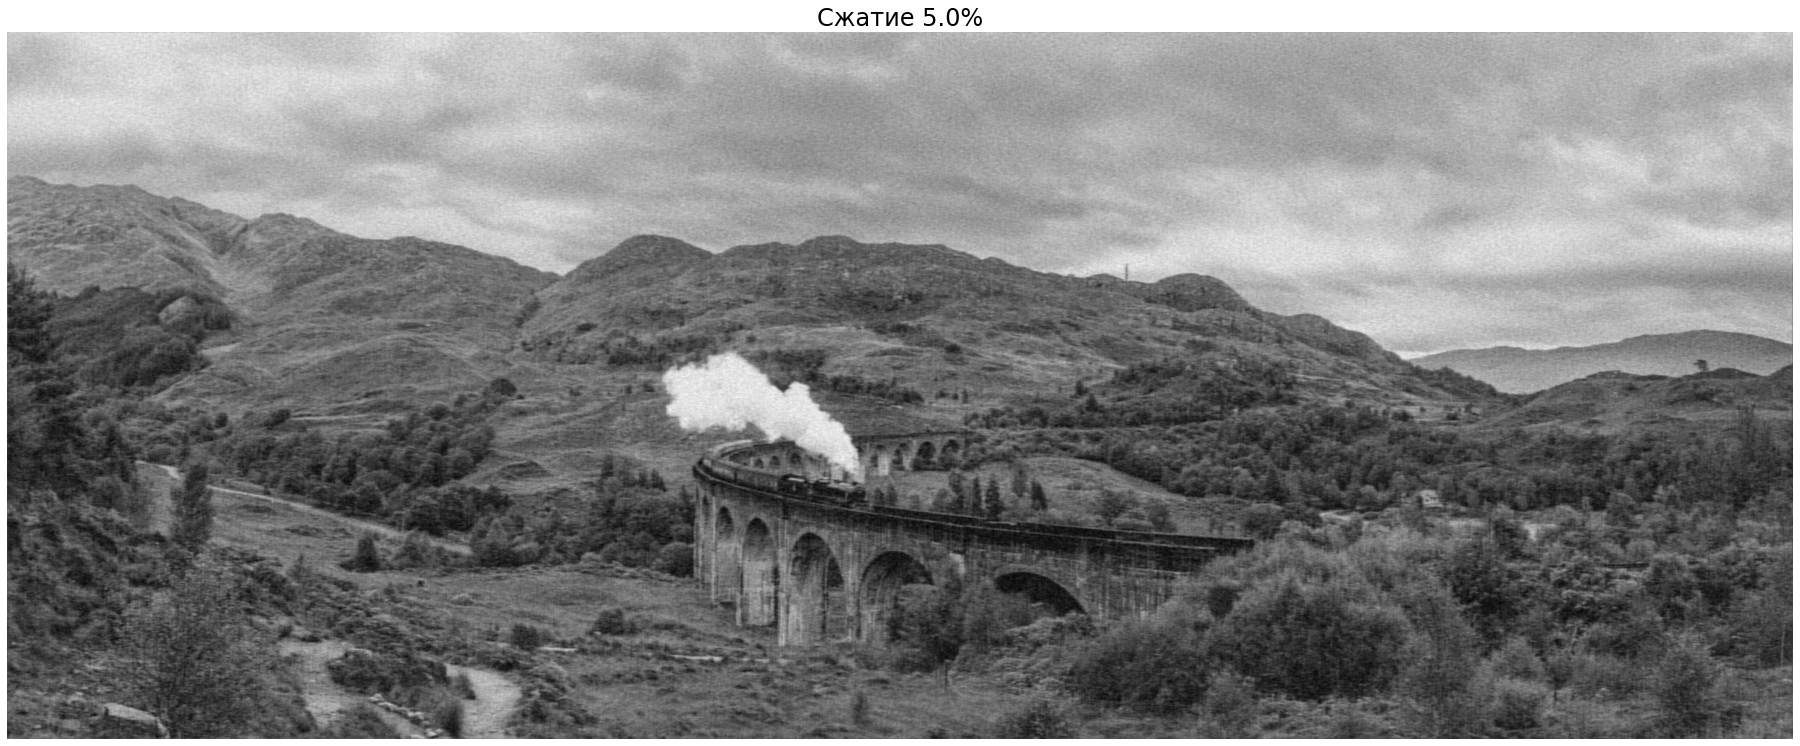

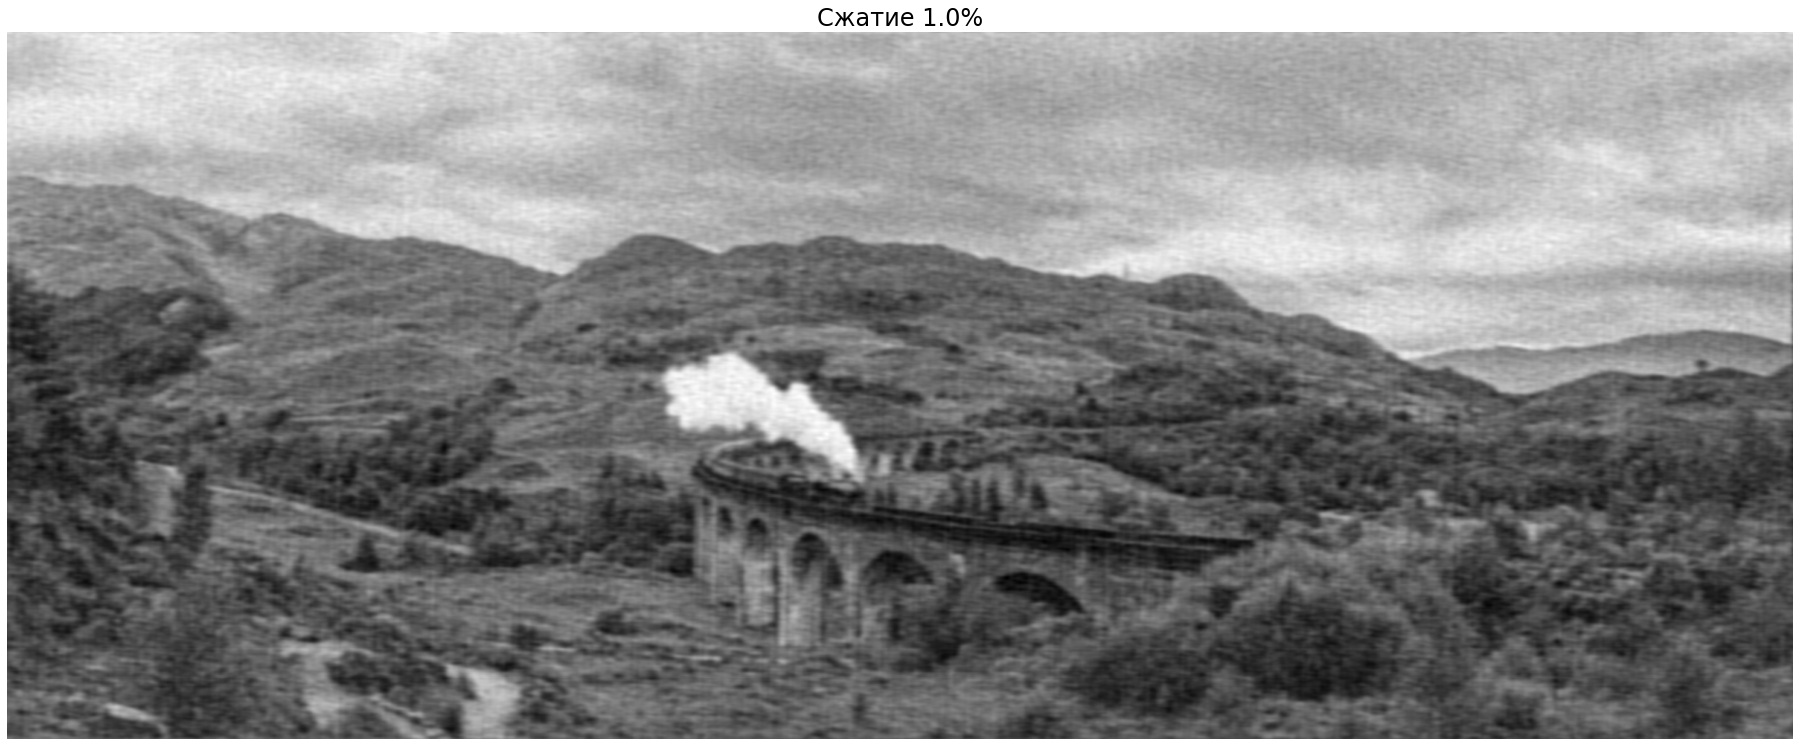

In [6]:
im = plt.imread('source/test_im2.jpg')
im = color.rgb2gray(im) # RGB к изображению в серых тонах


im_fft = fft2(im)
im_fft_sort = np.sort(np.abs(im_fft.reshape(-1)))

# обнулить малые коэффициенты и взять обратное ДПФ
for alpha in (0.1, 0.05, 0.01):
    # порог, так что доля ненулевых коэффициентов равна alpha 
    thresh = im_fft_sort[int(np.floor((1-alpha)*len(im_fft_sort)))]
    ind = np.abs(im_fft) > thresh
    im_fft_new = im_fft * ind
    im_new = ifft2(im_fft_new).real
    plt.figure(figsize=(32, 64))
    plt.imshow(im_new, cmap='gray')
    plt.axis('off')
    plt.title('Сжатие '+ str(alpha*100) + '%', fontsize=24)

### ДПФ для очищения изображения от шума

Шум особого вида можно эффективно удалять в частотной области.
А именно, это шум, вносимый высокочастотными синусоидами.

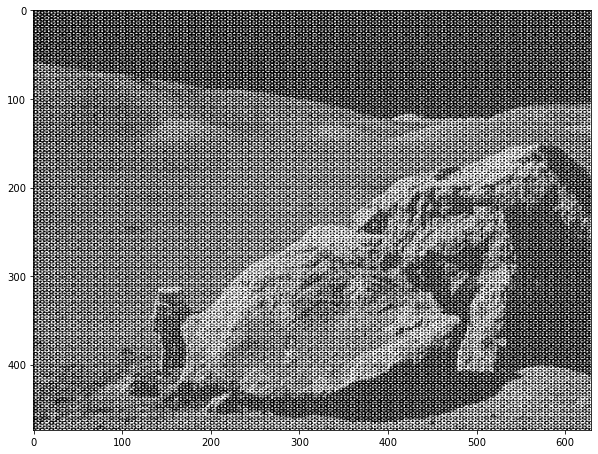

In [9]:
im = plt.imread('source/test_im_noise.png')
plt.figure(figsize=(10, 10))
plt.imshow(im, cmap='gray', vmin=0, vmax=1)

Используем ДПФ для этого изображения. При отображении ДПФ прологарифмируем результат, чтобы снизить динамический диапазон.

Text(0.5, 1.0, 'ДПФ зашумлённого изображения')

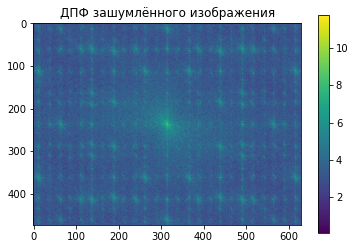

In [10]:
from scipy.fftpack import fft2, fftshift, ifft2

im_fft = fft2(im)
im_fft = fftshift(im_fft)

plt.imshow(np.log(1+np.abs(im_fft)))
plt.colorbar()
plt.title('ДПФ зашумлённого изображения')

Сохраним 1/10 значений спектра по столбцам и строкам в виде квадарта около нулевой частоты. Можно также применить круглую маску некоторого радиуса.

Text(0.5, 1.0, 'Отфильтрованный спектр')

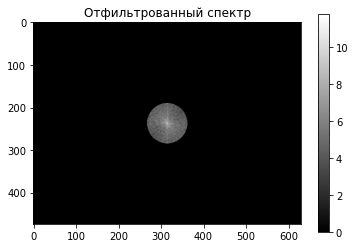

In [15]:
# Число строк, столбцов
r, c = im_fft.shape

# квадратная маска
keep_coef = 0.09
mask = np.zeros((r,c))
r1 = int(keep_coef*r)
c1 = int(keep_coef*c)
mask[int(r/2-r1):int(r/2+r1+1),int(c/2-c1):int(c/2+c1+1)] = 1

# круглая маска
mask = np.zeros((r,c))
rad = 0.10 * r
for i in range(r):
    for j in range(c):
        if (i-r/2)**2+(j-c/2)**2 < rad**2:
            mask[i,j] = 1

im_fft2 = im_fft*mask

plt.imshow(np.log(1+np.abs(im_fft2)), plt.cm.gray)
plt.colorbar()
plt.title('Отфильтрованный спектр')

Text(0.5, 1.0, 'Reconstructed Image')

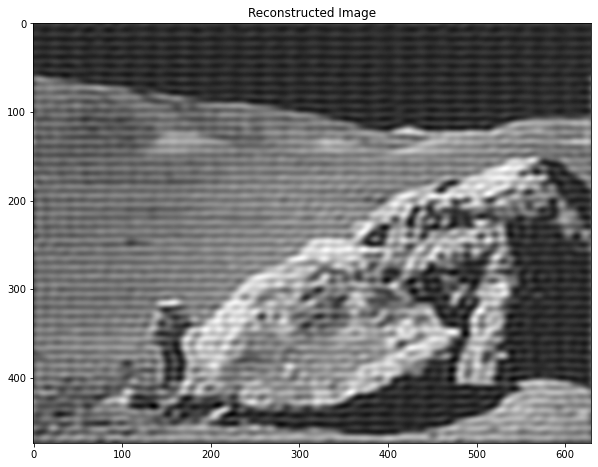

In [16]:
# Обратное ДПФ для восстановления отфильтрованного изображения

im_new = ifft2(fftshift(im_fft2)).real

plt.figure(figsize=(10, 10))
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')

Также, визуализируем идею о том, что серое изображение - это по сути график двумерной функция. 
Код для 3D визуализации изображения ниже

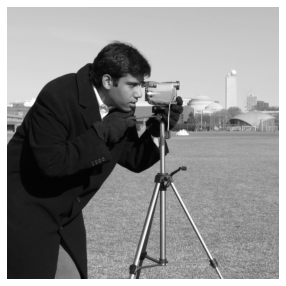

In [17]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

#im = imread('test_im2.jpg')
im = data.camera()
plt.figure(figsize=(10, 5))
plt.imshow(im, cmap='gray')
plt.axis('off');

<IPython.core.display.Javascript object>


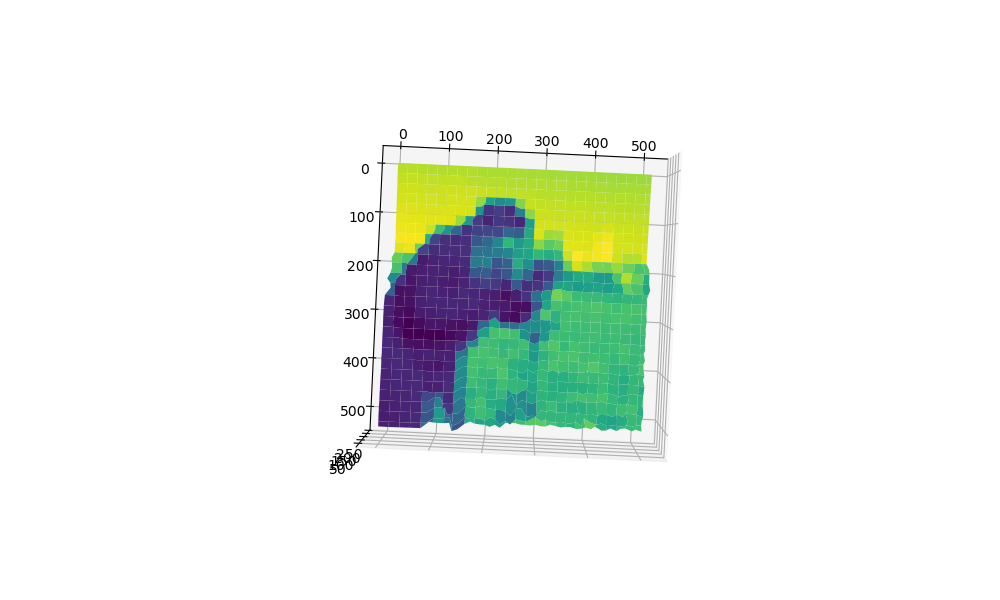

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# магическая комадна для отображение 3D  изображения
%matplotlib notebook


fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111,projection = '3d')
X, Y = np.meshgrid(np.arange(1,np.shape(im)[1]+1),np.arange(1,np.shape(im)[0]+1))
ax.plot_surface(X[0::10,0::10], Y[0::10,0::10], im[0::10,0::10], cmap = 'viridis', edgecolor = 'none')
ax.mouse_init()
ax.view_init(200,270)
# для вида сверху
ax.view_init(270,270)